In [1]:
import sqlite3
import pandas as pd
import numpy as np
from matplotlib import colors, cm, pyplot as plt
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

In [2]:
CONVERTED_DATABASE = '/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/converted-databases/exp-dwm-test-run-190719_Hela_Ecoli_1to1_01-converted.sqlite'

# frame types for PASEF mode
FRAME_TYPE_MS1 = 0
FRAME_TYPE_MS2 = 8


In [3]:
db_conn = sqlite3.connect(CONVERTED_DATABASE)
ms1_frame_properties_df = pd.read_sql_query("select Id,Time from frame_properties where MsMsType == {}".format(FRAME_TYPE_MS1), db_conn)
ms1_frame_ids = tuple(ms1_frame_properties_df.Id)
db_conn.close()

We consider a pixel to be an m/z bin. To maintain consistency with previous labelled training sets, and because it looks good for visual inspection, we will keep the tiles to be 18.0 Da wide.

In [4]:
PIXELS_X = 910
PIXELS_Y = 910  # equal to the number of scan lines

MZ_MIN = 100.0
MZ_MAX = 1700.0
SCAN_MAX = PIXELS_Y
SCAN_MIN = 1

MZ_PER_TILE = 18.0
TILES_PER_FRAME = int((MZ_MAX - MZ_MIN) / MZ_PER_TILE) + 1

In [5]:
def mz_from_tile_pixel(tile_id, pixel_x):
    assert (pixel_x >= 0) and (pixel_x <= PIXELS_X), "pixel_x not in range"
    assert (tile_id >= 0) and (tile_id <= TILES_PER_FRAME-1), "tile_id not in range"
    
    mz = (tile_id * MZ_PER_TILE) + ((pixel_x / PIXELS_X) * MZ_PER_TILE) + MZ_MIN
    return mz

In [6]:
mz = mz_from_tile_pixel(2,900)
mz

153.8021978021978

In [7]:
tile_id = int((mz - MZ_MIN) / MZ_PER_TILE)
tile_id

2

In [8]:
pixel_x = int(((mz - MZ_MIN) % MZ_PER_TILE) / MZ_PER_TILE * PIXELS_X)
pixel_x

900

In [9]:
def tile_pixel_x_from_mz(mz):
    assert (mz >= MZ_MIN) and (mz <= MZ_MAX), "m/z not in range"
    
    tile_id = int((mz - MZ_MIN) / MZ_PER_TILE)
    pixel_x = int(((mz - MZ_MIN) % MZ_PER_TILE) / MZ_PER_TILE * PIXELS_X)
    return (tile_id, pixel_x)

In [10]:
# choose a frame to test
FRAME_ID = ms1_frame_ids[int(len(ms1_frame_ids) / 2)]
FRAME_ID

5964

In [11]:
db_conn = sqlite3.connect(CONVERTED_DATABASE)
raw_points_df = pd.read_sql_query("select mz,scan,intensity from frames where frame_id == {}".format(FRAME_ID), db_conn)
db_conn.close()

In [12]:
tile_pixels_df = pd.DataFrame(raw_points_df.apply(lambda row: tile_pixel_x_from_mz(row.mz), axis=1).tolist(), columns=['tile_id', 'pixel_x'])

In [13]:
raw_points_df = pd.concat([raw_points_df, tile_pixels_df], axis=1)

In [14]:
raw_points_df.head()

,mz,scan,intensity,tile_id,pixel_x
0,1179.007791,41,90,59,859
1,1179.023944,42,147,59,860
2,714.338958,43,47,34,118
3,714.355723,43,85,34,119
4,1179.524763,43,112,59,885


In [15]:
raw_points_df.tile_id.min(),raw_points_df.tile_id.max()

(15, 80)

In [16]:
pixel_intensity_df = raw_points_df.groupby(by=['tile_id', 'pixel_x', 'scan'], as_index=False).intensity.sum()

In [17]:
pixel_intensity_df.head(20)

,tile_id,pixel_x,scan,intensity
0,15,213,815,100
1,16,63,734,9
2,16,769,708,80
3,16,769,710,21
4,16,769,724,113
5,16,770,711,32
6,16,770,715,92
7,16,770,716,52
8,16,770,721,127
9,16,770,723,110


In [18]:
pixel_intensity_df.intensity.min(), pixel_intensity_df.intensity.max(), pixel_intensity_df.intensity.mean(), pixel_intensity_df.intensity.median()

(9, 11599, 121.16522771960993, 68.0)

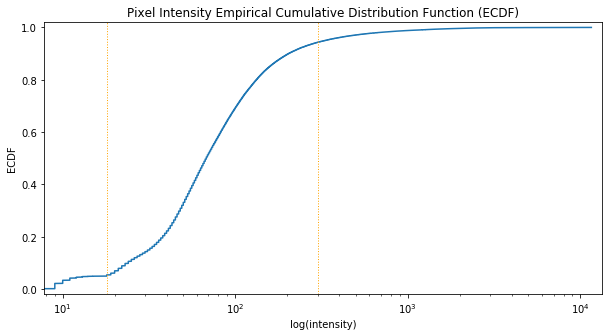

In [19]:
# determine the best clipping value using an ECDF

import statsmodels.api as sm
ecdf = sm.distributions.ECDF(pixel_intensity_df.intensity)

f, ax1 = plt.subplots()
plt.plot(ecdf.x, ecdf.y)
f.set_figheight(5)
f.set_figwidth(10)
plt.xscale('log')
plt.xlabel('log(intensity)')
plt.ylabel('ECDF')
plt.axvline(x=18, linestyle=':', linewidth=1, color='orange')
plt.axvline(x=300, linestyle=':', linewidth=1, color='orange')
plt.margins(0.02)
plt.title("Pixel Intensity Empirical Cumulative Distribution Function (ECDF)")
plt.show()

In [20]:
# calculate the colour to represent the intensity
colour_map = cm.get_cmap(name='rainbow')
norm = colors.LogNorm(vmin=18, vmax=300, clip=True)  # aiming to get good colour variation in the lower range, and clipping everything else


In [21]:
%%time

# calculate the colour to represent the intensity
colour_l = []
for r in zip(pixel_intensity_df.intensity):
    colour_l.append((colour_map(norm(r[0]), bytes=True)[:3]))
pixel_intensity_df['colour'] = colour_l

CPU times: user 50 s, sys: 169 ms, total: 50.2 s
Wall time: 50.1 s


In [23]:
len(pixel_intensity_df)

200378

In [24]:
pixel_intensity_df.head()

,tile_id,pixel_x,scan,intensity,colour
0,15,213,815,100,"(184, 239, 146)"
1,16,63,734,9,"(127, 0, 255)"
2,16,769,708,80,"(142, 253, 171)"
3,16,769,710,21,"(99, 43, 254)"
4,16,769,724,113,"(206, 225, 131)"


In [25]:
pixel_intensity_df.loc[pixel_intensity_df.intensity.idxmax()]

tile_id               34
pixel_x              118
scan                  78
intensity          11599
colour       (255, 0, 0)
Name: 76944, dtype: object

In [26]:
tile_33_df = pixel_intensity_df[(pixel_intensity_df.tile_id == 33)]

In [27]:
tile_33_df.head()

,tile_id,pixel_x,scan,intensity,colour
64408,33,13,89,96,"(176, 243, 151)"
64409,33,13,92,112,"(204, 226, 132)"
64410,33,13,97,74,"(128, 254, 179)"
64411,33,13,102,76,"(134, 254, 176)"
64412,33,13,106,81,"(144, 253, 170)"


In [44]:
# create an image of the whole frame
tile_im_array = np.zeros([PIXELS_Y+1, PIXELS_X+1, 3], dtype=np.uint8)  # container for the image
for r in zip(tile_33_df.pixel_x, tile_33_df.scan, tile_33_df.colour):
    x = r[0]
    y = r[1]
    c = r[2]
    tile_im_array[y,x,:] = c

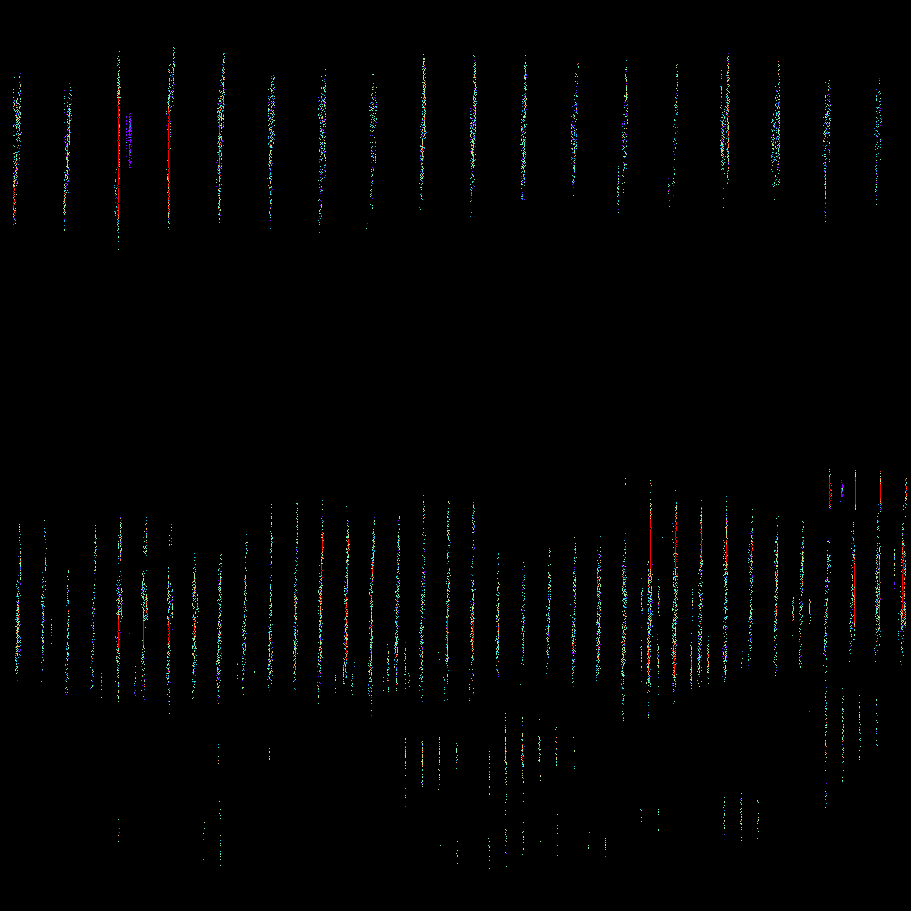

In [45]:
tile = Image.fromarray(tile_im_array, 'RGB')
tile

In [46]:
tile.save('/Users/darylwilding-mcbride/Downloads/prototype-tile.png')

In [47]:
%%time

z = np.array([0,0,0])
for x in range(4, PIXELS_X-4):
    for y in range(4, PIXELS_Y-4):
        c = tile_im_array[y,x]
        if (c == z).all():
            n = []
            n.append(tile_im_array[y+1,x-1])
            n.append(tile_im_array[y+1,x])
            n.append(tile_im_array[y+1,x+1])
            
            n.append(tile_im_array[y-1,x-1])
            n.append(tile_im_array[y-1,x])
            n.append(tile_im_array[y-1,x+1])

            n.append(tile_im_array[y+2,x-1])
            n.append(tile_im_array[y+2,x])
            n.append(tile_im_array[y+2,x+1])
            
            n.append(tile_im_array[y-2,x-1])
            n.append(tile_im_array[y-2,x])
            n.append(tile_im_array[y-2,x+1])

            n.append(tile_im_array[y+3,x-1])
            n.append(tile_im_array[y+3,x])
            n.append(tile_im_array[y+3,x+1])
            
            n.append(tile_im_array[y-3,x-1])
            n.append(tile_im_array[y-3,x])
            n.append(tile_im_array[y-3,x+1])

            n.append(tile_im_array[y+4,x-1])
            n.append(tile_im_array[y+4,x])
            n.append(tile_im_array[y+4,x+1])
            
            n.append(tile_im_array[y-4,x-1])
            n.append(tile_im_array[y-4,x])
            n.append(tile_im_array[y-4,x+1])

            n.append(tile_im_array[y,x-1])
            n.append(tile_im_array[y,x+1])
            
            neighbours_a = np.array(n)
            tile_im_array[y,x] = np.mean(neighbours_a, axis=0)

CPU times: user 25 s, sys: 36.1 ms, total: 25 s
Wall time: 25 s


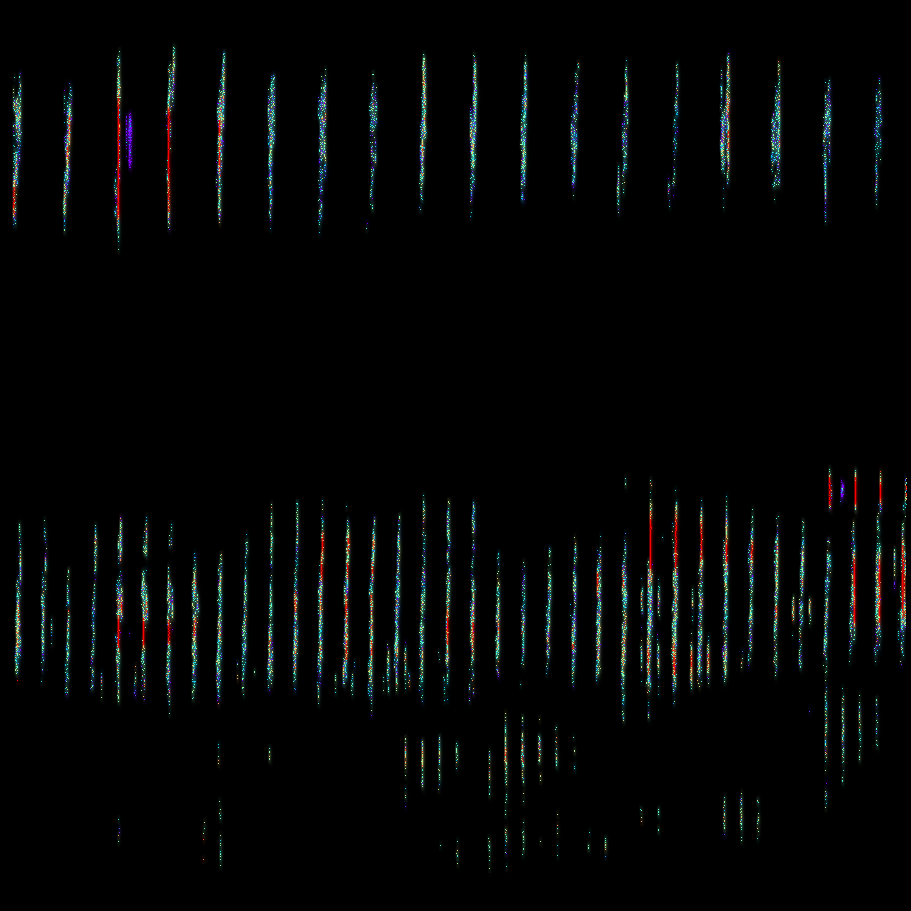

In [48]:
tile = Image.fromarray(tile_im_array, 'RGB')
tile

In [49]:
tile.save('/Users/darylwilding-mcbride/Downloads/prototype-tile-average-filled.png')